In [1]:
'''
1.Torch Multimodal is the library powered by pytorch consisting of building blocks and end to end examples
aiming to enable and accelerate research in Multimodality

2. Use Pretrained Model Flava and finetune on visual question answering dataset

3. Flava Model consists of two encoders and a decoder one encoder for text and one for Image
'''

'\nTorch Multimodal is the library powered by pytorch consisting of building blocks and end to end examples\naiming to enable and accelerate research in Multimodality\n'

In [2]:
from IPython.display import clear_output

In [4]:
!pip3 install torchmultimodal-nightly
!pip3 install datasets
!pip3 install transformers
clear_output()

In [5]:
!wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
!tar xf vocab.tar.gz
clear_output()

In [36]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from collections import defaultdict
from functools import partial
from transformers import BertTokenizer
from torchmultimodal.models.flava.model import flava_model_for_classification
from torch import nn
from torch.utils.data import DataLoader

In [6]:
with open('/content/vocabs/answers_textvqa_more_than_1.txt') as f:
  vocab = f.readlines()

In [9]:
len(vocab)

3997

In [11]:
answer_to_index = {}
for idx,entry in enumerate(vocab): #creating a disctionay with each answer as a class label
  answer_to_index[entry.strip('\n')] = idx

In [13]:
dataset = load_dataset("textvqa")
clear_output()

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name'],
        num_rows: 34602
    })
    validation: Dataset({
        features: ['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name'],
        num_rows: 5734
    })
})

Question: what is the identification number of the plane?
Answer: ['n10349', 'n10349', 'n10349', 'n10349', 'n10349', 'n10349', 'n10349', 'n10349', 'n10349', 'n10349']


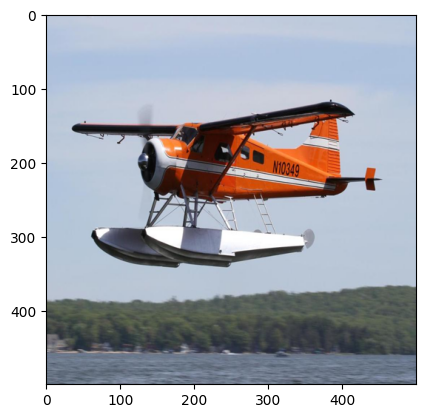

In [21]:
idx = 100
print(f"Question: {dataset['train'][idx]['question']}")
print(f"Answer: {dataset['train'][idx]['answers']}")
im = np.asarray(dataset["train"][idx]["image"].resize((500,500)))
plt.imshow(im)
plt.show()

In [25]:
'''
1. Converting images and text to the tensor.
2. Images are converted to standard form by reshaping using torch.transforms
3. Converting text data to the tensor using tokenizer
4. Output is considered based on the maximu vote
'''

'\n1. Converting images and text to the tensor.\n2. Images are converted to standard form by reshaping using torch.transforms\n3. Converting text data to the tensor using tokenizer\n4. Output is considered based on the maximu vote\n'

In [30]:
def transform(tokenizer, input):
  batch = {}

  # Resizing the image step
  img_transforms = transforms.Compose([transforms.ToTensor(),transforms.Resize([224,224])])
  image = img_transforms(input["image"][0].convert("RGB"))
  batch["image"] = image

  ans_to_count = defaultdict(int)

  for ans in input["answers"][0]: #taking the count of each label in the answers list
    ans_to_count[ans] += 1

  max_value = max(ans_to_count,key=ans_to_count.get) #getting the token of the max values -- label
  ans_idx = answer_to_index.get(max_value,0) #converting thr label to index
  batch["answers"] = torch.as_tensor([ans_idx])
  return batch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",padding=True,max_length=512)
transform = partial(transform,tokenizer)
dataset.set_transform(transform)

In [28]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name'],
        num_rows: 34602
    })
    validation: Dataset({
        features: ['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['image_id', 'question_id', 'question', 'question_tokens', 'image', 'image_width', 'image_height', 'flickr_original_url', 'flickr_300k_url', 'answers', 'image_classes', 'set_name'],
        num_rows: 5734
    })
})

In [35]:
model = flava_model_for_classification(num_classes=len(vocab))

flava_for_pretraining_unified_text_encoder.pt: 1.43GB [00:16, 86.2MB/s]                           


In [45]:
BATCH_SIZE = 2
MAX_STEPS = 3

train_dataloader = DataLoader(dataset["train"], batch_size= BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())

epochs = 1
for _ in range(epochs):
  for idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    out = model(text = batch["input_ids"], image = batch["image"], labels = batch["answers"])
    loss = out.loss
    loss.backward()
    optimizer.step()
    print(f"Loss at step {idx} = {loss}")
    if idx >= MAX_STEPS-1:
      break